In [1]:
import os
import numpy as np
import cv2 as cv
import pickle
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [2]:
from estimate_trajectory import *
data_dir = "public_tests/00_test_slam_input"
config = SFMConfig()

frame_to_image_path = get_frame_to_image_path(data_dir)
frame_to_keypoints = get_frame_to_keypoints(
        frame_to_image_path, data_dir, 
        save_dir=config.keypoints_save_dir, 
        method=config.keypoints_method,
        n_keypoints=config.n_keypoints,
        overwrite_cache=config.keypoints_overwrite_cache
    )
frame_to_extrinsic_mat = get_frame_to_extrinsic_matrix(data_dir)
anchor_frames = list(frame_to_extrinsic_mat.keys())

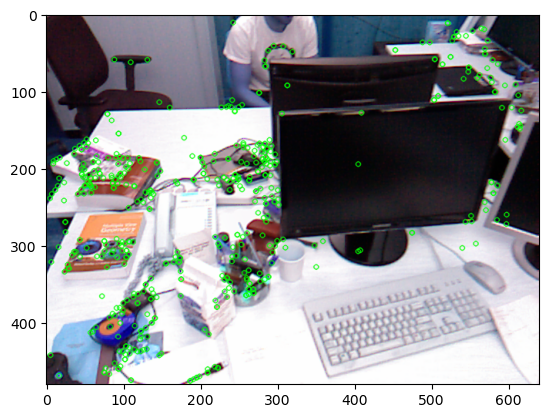

In [3]:
frame_id = 0
img = cv.imread(frame_to_image_path[frame_id])
kp = frame_to_keypoints[frame_id].kp
plt.imshow(cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0))

In [4]:
frames_to_matches = match_anchor_keypoints(
    anchor_frames, frame_to_keypoints,
    method=config.matching_method,
    ratio_threshold=config.matching_ratio_threshold,
    ransacReprojThreshold=config.matching_ransac_threshold
)

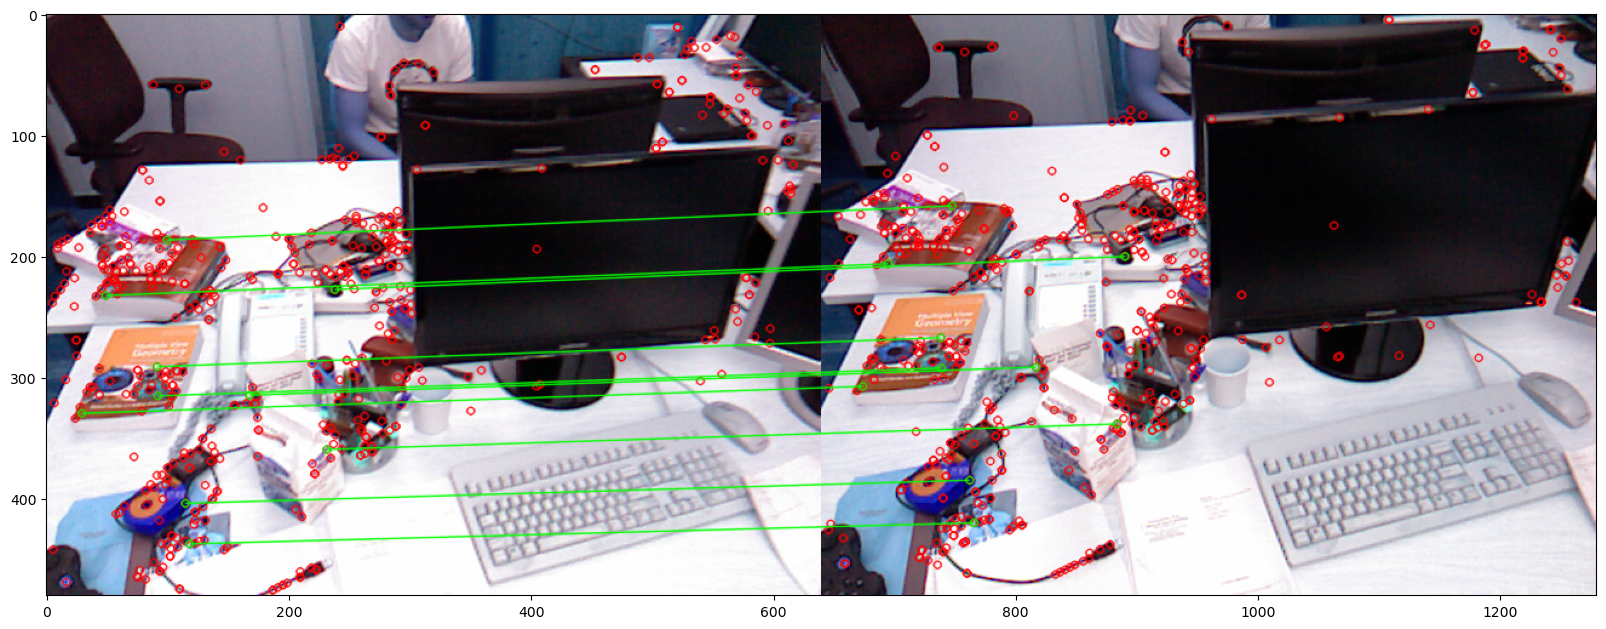

In [5]:
frame_id1 = 0
frame_id2 = 1
img1 = cv.imread(frame_to_image_path[frame_id1])
img2 = cv.imread(frame_to_image_path[frame_id2])
kp1 = frame_to_keypoints[frame_id1].kp
kp2 = frame_to_keypoints[frame_id2].kp
matches = frames_to_matches[(frame_id1, frame_id2)]
matches_to_draw = 10
matchesMask = np.zeros((len(matches)))
matchesMask[np.random.choice(len(matches), matches_to_draw)] = 1
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask=matchesMask,
                   flags = 0)
plt.figure(figsize=(20,20))
plt.imshow(cv.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params))

In [10]:
def plot_track(frame_to_image_paths, frame_to_keypoints, tracks, track_idx):
    frames = []
    fig = plt.figure()
    track = tracks[track_idx]
    print(f"Track {track_idx} of size {len(track)}")
    for i in range(len(track)):
        frame_id = track.get_frame_by_index(i)
        pt = frame_to_keypoints[frame_id].kp[track[i]].pt
        pt = tuple(map(int, pt))
        img = cv.imread(frame_to_image_paths[frame_id])
        img = cv.circle(img, pt, 5, color=(0, 255, 0), thickness=10)
        frames.append([plt.imshow(img, animated=True)])
    ani = animation.ArtistAnimation(fig, frames, interval=400, blit=True,
                                repeat_delay=1000)
    ani.save(f"videos/track_{track_idx}.mp4")

In [11]:
tracks = get_tracks(frames_to_matches, track_min_length=5)
print(f"num tracks {len(tracks)}")

num tracks 292


Track 107 of size 9


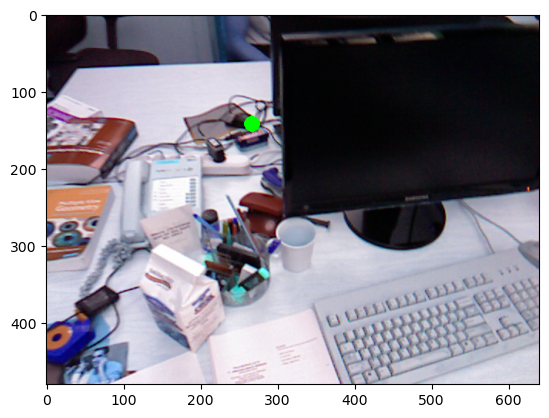

In [14]:
track_idx = np.random.choice(len(tracks)) #118 #list(sorted(enumerate(tracks), key=lambda x: -len(x[1])))[0][0]
plot_track(frame_to_image_path, frame_to_keypoints, tracks, track_idx)

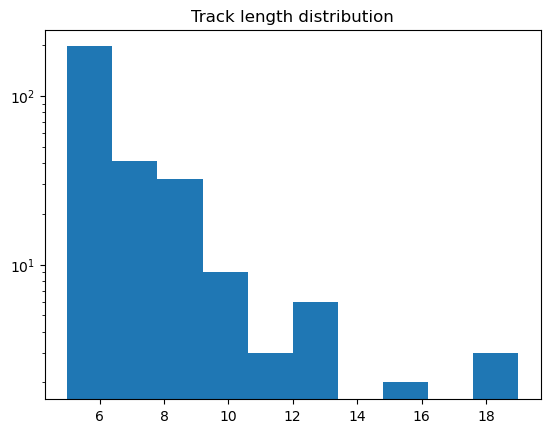

In [17]:
plt.hist([len(track.items) for track in tracks], bins=10)
plt.yscale('log')
plt.title('Track length distribution')
plt.show()

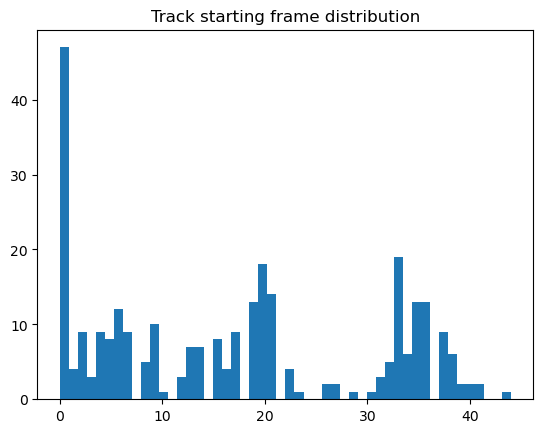

In [18]:
plt.hist([track.frames[0] for track in tracks], bins=50);
plt.title('Track starting frame distribution');

Text(0.5, 1.0, 'Frames distribution')

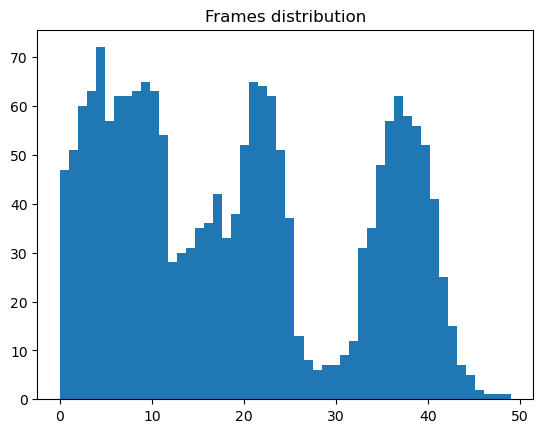

In [21]:
plt.hist(np.array([frame for track in tracks for frame in track.frames]), bins=50);
plt.title('Frames distribution')